<a href="https://colab.research.google.com/github/AnitaKamani/computational-intelligence-class-9902/blob/G01-Spoken-Digit-Classification/G01-Spoken-Digit-Classification/Spoken_Digit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pydub

In [ ]:
# connecting to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing libraries

In [ ]:
import os
from tqdm import tqdm
import random
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

### Importing datas and feature extracting

In [ ]:
# sound directory of cut silence audio

dir = '/content/drive/MyDrive/CI_files/Spoken_Digit_Classification/'

In [ ]:
# importing audios and collecting labels

sounds_dir = dir + "Audio/cut_silence/"
# integer of sampels per audio
samples=30
# list for data
data_list = []
# list for label
data_label = []
# importing the audio file names into "mylist" array
mylist = os.listdir(sounds_dir)
# shuffling audio names
random.shuffle(mylist)

# using tqdm for showing a progress bar 
for i in tqdm(range(len(mylist)), position=0, leave=True):
    # making file path for each file
    path = sounds_dir + mylist[i]
    # using librosa to extract data and sampling_rate from audios
    data, sampling_rate = librosa.load(path)
    # extracting audio feature using mfcc number of rows = samples 
    # according to file length we have feature number of columns
    # but using np.mean with axis 1 we are able to convert (samples,col) shape into (samples,) shape
    # this function calculates the average of each row
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=samples), axis=1)
    # appending mfccs to data_list
    data_list.append(mfccs)
    # appending labels collected from first char of the name of each audio file ex: 9_yweweler_48.wav -> label='9'
    data_label.append(int(mylist[i][0]))

100%|██████████| 2808/2808 [00:53<00:00, 52.92it/s]


In [ ]:
# length and example

print("number of data: ", len(data_list))
print("number of label: ", len(data_label))
print("data ex: ", data_list[10:11])
print("label ex: ", data_label[10:11])

number of data:  2808
number of label:  2808
data ex:  [array([-548.5122    ,  166.13968   ,  -66.13242   ,   44.67197   ,
         38.86034   ,  -47.4652    ,   -4.0596566 ,   -8.832043  ,
        -30.090097  ,    3.5134807 ,  -17.342863  ,  -21.36366   ,
         12.159886  ,   -4.4861965 ,   -2.267304  ,    9.768618  ,
        -15.463841  ,    0.7378615 ,   13.42748   ,  -18.990982  ,
         -7.781482  ,    4.8500385 ,  -19.259123  ,   -8.833177  ,
          2.3469172 ,   -8.304173  ,    2.036557  ,   -0.60702324,
        -10.933233  ,    1.5726228 ], dtype=float32)]
label ex:  [6]


In [ ]:
# converting arrays to np_array

data_np = np.array(data_list)
label_np = np.array(data_label)

In [ ]:
"""
cutting the data_set into three portions: train, validation, test
using train_test_split:
first we chop 80% of data for train and put remaining 20% into tmp
then we will chop 50% of tmp (10% of total) into test and the remaining data (10% of total) into valid
"""
x_train, x_temp, y_train, y_temp = train_test_split(data_np, label_np, test_size=0.2, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train))
print(len(x_valid))
print(len(x_test))

2246
281
281


### Model

In [ ]:
"""
we will use keras to create our model:

input layer should be 30 nodes since we have 30 features extracted
first hidden layer is 120 nodes
second hidden layer is also 120 nodes
drop out
output layer should be 10 nodes since we have digits 0 to 9

source available in: https://keras.io/api/models/model/#model-class
"""

# clear the [previous] model
# available in: https://stackoverflow.com/questions/52133347/how-can-i-clear-a-model-created-with-keras-and-tensorflowas-backend
tf.keras.backend.clear_session()

# create model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(samples,)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)])

# summary method available in: https://keras.io/api/models/model/#summary-method
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               3720      
_________________________________________________________________
dense_1 (Dense)              (None, 120)               14520     
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1210      
Total params: 19,450
Trainable params: 19,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set compile options

"""
defining optimizer:
available in: https://keras.io/api/optimizers/

choosing adam optimizzer:
help: https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/


choosing SparseCategoricalCrossentropy loss function:
https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class
https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class
from two fourms above we conclude that:
if we have "one_hot" label representation we should use : CategoricalCrossentropy
and if we have "Integer" labels we should use : SparseCategoricalCrossentropy
here we have Integers

defining accuracy metric
available in: https://keras.io/api/metrics/accuracy_metrics/
"""

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###Train

In [ ]:
# training the model and collection the loss and accuracy in each epoch

epochs = 25

# two list for collecting evaluation data
evals_vaild = [[], []]
evals_train = [[], []]

# traiing model in n epoches and batch_size=3
for i in range(epochs):
    print(i)
    model.fit(x_train, y_train, batch_size=3)
    # collecting evaluations
    evaluate_valid = model.evaluate(x_valid, y_valid)
    evaluate_train = model.evaluate(x_train, y_train)

    evals_vaild[0].append(evaluate_valid[0])
    evals_vaild[1].append(evaluate_valid[1])
    evals_train[0].append(evaluate_train[0])
    evals_train[1].append(evaluate_train[1])


0
71/71 [==============================] - 0s 2ms/step - loss: 1.4171 - accuracy: 0.4662
1
71/71 [==============================] - 0s 1ms/step - loss: 1.2087 - accuracy: 0.5775
2
71/71 [==============================] - 0s 2ms/step - loss: 0.8910 - accuracy: 0.6768
3
71/71 [==============================] - 0s 2ms/step - loss: 0.7592 - accuracy: 0.7311
4
71/71 [==============================] - 0s 2ms/step - loss: 0.7460 - accuracy: 0.7427
5
71/71 [==============================] - 0s 2ms/step - loss: 0.5498 - accuracy: 0.8010
6
71/71 [==============================] - 0s 2ms/step - loss: 0.5068 - accuracy: 0.8188
7
71/71 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.8192
8
71/71 [==============================] - 0s 1ms/step - loss: 0.4156 - accuracy: 0.8593
9
71/71 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.8905
10
71/71 [==============================] - 0s 1ms/step - loss: 0.4571 - accuracy: 0.8317
11
71/71 [==========

###Plots

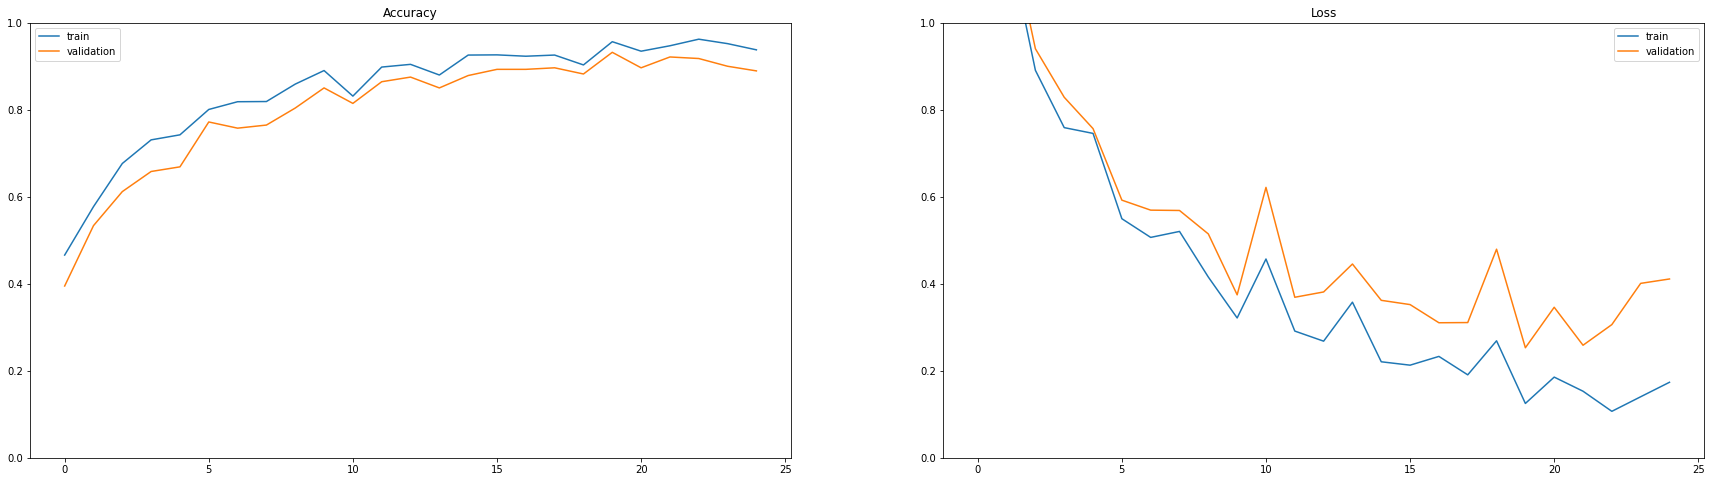

In [ ]:
# drawing the plot for accuacy and loss in train and valid

plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.ylim([0,1])
plt.plot(range(epochs),evals_train[1],label="train")
plt.plot(range(epochs),evals_vaild[1],label="validation")
plt.legend()
plt.title("Accuracy")
plt.subplot(1,2,2)
plt.ylim([0,1])
plt.plot(range(epochs),evals_train[0],label="train")
plt.plot(range(epochs),evals_vaild[0],label="validation")
plt.legend()
plt.title("Loss")
plt.show()

###TEST

In [ ]:
# evaluating model
# available in: https://keras.io/guides/training_with_built_in_methods/

model.evaluate(x_test,  y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.2989 - accuracy: 0.9039


[0.2989061772823334, 0.9039145708084106]

In [ ]:
# testing some inputs to see the result
# we can see that usualldy the label found in the second command has the largest value in the first array
arr = model(x_test[40:41])
print(arr)
answer = np.argmax(arr)
print(answer)
print(y_test[40:41])

tf.Tensor(
[[-16.453619  -20.219076  -20.806492   -2.7242463 -15.747955  -13.049114
    7.0720077 -21.952307   14.995591  -15.626367 ]], shape=(1, 10), dtype=float32)
8
[8]


### Saving and Loading model from files

In [ ]:
# saving model
# available in: https://keras.io/api/models/model_saving_apis

tf.keras.models.save_model(
    model,
    filepath=dir + "model",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

In [ ]:
# loading model
# available in: https://keras.io/api/models/model_saving_apis

model2 = tf.keras.models.load_model(
    filepath=dir + "model", custom_objects=None, compile=True, options=None
)

#we are done

In [ ]:
inp = np.array([[-320.501     ,   70.99223   ,   22.881935  ,   10.269344  ,
         16.397808  ,   17.173342  ,    6.1273956 ,   21.855566  ,
         15.697491  ,   12.020102  ,    8.335047  ,   10.396284  ,
          7.6446233 ,   11.368333  ,    4.271583  ,    2.8540947 ,
         -2.9313676 ,    0.8210173 ,   -0.45024464,    6.519269  ]])
arr = model2(inp[0:1])
answer = np.argmax(arr)
print(arr)
print(answer)

In [ ]:
# a code to generate featers array from a non_cutted audio file

import librosa
import numpy as np
from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.io.wavfile import write


def create_audio_array(path, file_name, scale=1):
    cut(path + file_name, path + "final.wav", scale=1)
    np_array = audio_to_array(path + "final.wav")
    return np_array


# removing silence
def cut(file_path, des_path, scale=1.5, leng=200):
    audio = AudioSegment.from_wav(file_path)

    # loudness = -40 if int(audio.dBFS) > -40 else int(audio.dBFS)-5
    loudness = int(audio.dBFS * scale)
    print(int(audio.dBFS))
    print(loudness)
    audio_chunks = split_on_silence(audio, min_silence_len=leng, silence_thresh=loudness)

    # if code coudnt find a part -> try shortning the silence limit
    if len(audio_chunks) == 0 and leng > 50:
        cut(audio, leng=leng - 20)
    elif len(audio_chunks) > 0:
        audio_chunks[0].export(des_path, format="wav")


def audio_to_array(audio_path):
    data, sampling_rate = librosa.load(str(audio_path))
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=20), axis=1)

    data_np = np.array([mfccs])
    return data_np

In [ ]:
path = dir
array = create_audio_array(path, "tmp.wav")
print(array)
arr = model(array)
answer = np.argmax(arr)
print(answer)